In [108]:
#Import important library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.style.use('ggplot')

#Import big mart data base training set & test set
train = pd.read_csv('train_bigmart.csv')
test = pd.read_csv('test_bigmart.csv')

In [109]:
#Join Train and Test Data Set
train['source'] = 'train'
test['source'] = 'test'

data = pd.concat([train, test], ignore_index = True, sort = False)

#Check data set after concatenate 
print(data.head(10))

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15        9.300          Low Fat         0.016047   
1           DRC01        5.920          Regular         0.019278   
2           FDN15       17.500          Low Fat         0.016760   
3           FDX07       19.200          Regular         0.000000   
4           NCD19        8.930          Low Fat         0.000000   
5           FDP36       10.395          Regular         0.000000   
6           FDO10       13.650          Regular         0.012741   
7           FDP10          NaN          Low Fat         0.127470   
8           FDH17       16.200          Regular         0.016687   
9           FDU28       19.200          Regular         0.094450   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  1

# Imputate Missing Value

In [110]:
#Replace value
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'low fat':'Low Fat', 'LF':'Low Fat', 'reg':'Regular'})

In [111]:
#Impute missing value for Item Visibility with median
data['Item_Visibility'] = data['Item_Visibility'].replace(0, np.nan)

median = data['Item_Visibility'].median()

#Fill NaN with median
data['Item_Visibility'] = data['Item_Visibility'].fillna(median)

In [112]:
#Impute value with mean for Item_Weight due to it is not sensitive with Outlier
mean_wt = data['Item_Weight'].mean()

data['Item_Weight'] = data['Item_Weight'].fillna(mean_wt).astype('float')


In [113]:
#Impute Category on Outlet Size with Most Common Class
most_frequent = data['Outlet_Size'].value_counts().idxmax()

data['Outlet_Size'] = data['Outlet_Size'].fillna(most_frequent).astype('object')


In [114]:
#After impute all missing value, double check missing value
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [115]:
#Years of Operation:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [116]:
#Get the first two characters of ID:
data['Item_Category'] = data['Item_Identifier'].apply(lambda x: x[0:2])

#Rename them as Food , Non-Consumable, and Drink
data['Item_Category'] = data['Item_Category'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})

data['Item_Category'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Category, dtype: int64

In [117]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Years,Item_Category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,14,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,4,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,14,Food
3,FDX07,19.20,Regular,0.057851,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,train,15,Food
4,NCD19,8.93,Low Fat,0.057851,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,26,Non-Consumable


# Implemenation of FeatureTools

In [118]:
#Saving 'Item_Outlet_Sales'
sales = data['Item_Outlet_Sales']
data.drop('Item_Outlet_Sales', axis=1, inplace=True)
data.drop('Outlet_Establishment_Year', axis=1, inplace=True)

In [120]:
#Create Specifice Data Id from Item_Identifier and Outlet_Identifier
data['id'] = data['Item_Identifier']+data['Outlet_Identifier']
data.drop(['Item_Identifier'], axis=1, inplace=True)

In [121]:
#Import FeatureTools Library
import featuretools as ft

#Create entityset 'es'
es = ft.EntitySet(id='sales')

#adding dataframe
es.entity_from_dataframe(entity_id='bigmart', dataframe=data, index='id')

Entityset: sales
  Entities:
    bigmart [Rows: 14204, Columns: 13]
  Relationships:
    No relationships

In [122]:
#Create another entity table
es.normalize_entity(base_entity_id='bigmart', new_entity_id='outlet', index='Outlet_Identifier',
                   additional_variables=['Outlet_Years', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Type'])

Entityset: sales
  Entities:
    bigmart [Rows: 14204, Columns: 9]
    outlet [Rows: 10, Columns: 5]
  Relationships:
    bigmart.Outlet_Identifier -> outlet.Outlet_Identifier

In [123]:
#Deep Feature Synthesis
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='bigmart', max_depth=2, verbose=1, n_jobs=3)

Built 39 features
EntitySet scattered to 3 workers in 3 seconds                                                                          
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "D:\Python\lib\site-packages\distributed\utils.py", line 714, in log_errors
    yield
  File "D:\Python\lib\site-packages\distributed\client.py", line 1249, in _close
    quiet_exceptions=(CancelledError,),
  File "D:\Python\lib\site-packages\tornado\gen.py", line 588, in with_timeout
    chain_future(future_converted, result)
  File "D:\Python\lib\site-packages\tornado\concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "D:\Python\lib\site-packages\tornado\concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "D:\Python\lib\site-packages\tornado\concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "D:\Python\lib\site-packages\distr

In [124]:
#Overview all features
feature_matrix.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'source', 'Item_Category',
       'outlet.Outlet_Years', 'outlet.Outlet_Size',
       'outlet.Outlet_Location_Type', 'outlet.Outlet_Type',
       'outlet.SUM(bigmart.Item_MRP)', 'outlet.SUM(bigmart.Item_Weight)',
       'outlet.SUM(bigmart.Item_Visibility)', 'outlet.STD(bigmart.Item_MRP)',
       'outlet.STD(bigmart.Item_Weight)',
       'outlet.STD(bigmart.Item_Visibility)', 'outlet.MAX(bigmart.Item_MRP)',
       'outlet.MAX(bigmart.Item_Weight)',
       'outlet.MAX(bigmart.Item_Visibility)', 'outlet.SKEW(bigmart.Item_MRP)',
       'outlet.SKEW(bigmart.Item_Weight)',
       'outlet.SKEW(bigmart.Item_Visibility)', 'outlet.MIN(bigmart.Item_MRP)',
       'outlet.MIN(bigmart.Item_Weight)',
       'outlet.MIN(bigmart.Item_Visibility)', 'outlet.MEAN(bigmart.Item_MRP)',
       'outlet.MEAN(bigmart.Item_Weight)',
       'outlet.MEAN(bigmart.Item_Visibility)', 'outlet.COUNT(bigmart

In [125]:
feature_matrix.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,source,Item_Category,outlet.Outlet_Years,outlet.Outlet_Size,...,outlet.MEAN(bigmart.Item_Visibility),outlet.COUNT(bigmart),outlet.NUM_UNIQUE(bigmart.Item_Fat_Content),outlet.NUM_UNIQUE(bigmart.source),outlet.NUM_UNIQUE(bigmart.Item_Category),outlet.NUM_UNIQUE(bigmart.Item_Type),outlet.MODE(bigmart.Item_Fat_Content),outlet.MODE(bigmart.source),outlet.MODE(bigmart.Item_Category),outlet.MODE(bigmart.Item_Type)
id,,,,,,,,,,,,,,,,,,,,,
FDA15OUT049,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,train,Food,14,Medium,...,0.063180,1550,2,2,3,16,Low Fat,train,Food,Fruits and Vegetables
DRC01OUT018,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,train,Drinks,4,Medium,...,0.063831,1546,2,2,3,16,Low Fat,train,Food,Fruits and Vegetables
FDN15OUT049,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,train,Food,14,Medium,...,0.063180,1550,2,2,3,16,Low Fat,train,Food,Fruits and Vegetables
FDX07OUT010,19.20,Regular,0.057851,Fruits and Vegetables,182.0950,OUT010,train,Food,15,Medium,...,0.105254,925,2,2,3,16,Low Fat,train,Food,Fruits and Vegetables
NCD19OUT013,8.93,Low Fat,0.057851,Household,53.8614,OUT013,train,Non-Consumable,26,High,...,0.063892,1553,2,2,3,16,Low Fat,train,Food,Fruits and Vegetables


In [126]:
drop = ['outlet.NUM_UNIQUE(bigmart.Item_Fat_Content)',
       'outlet.NUM_UNIQUE(bigmart.Item_Type)',
       'outlet.NUM_UNIQUE(bigmart.Item_Category)',
       'outlet.NUM_UNIQUE(bigmart.source)',
       'outlet.MODE(bigmart.Item_Fat_Content)',
       'outlet.MODE(bigmart.Item_Type)', 'outlet.MODE(bigmart.Item_Category)',
       'outlet.MODE(bigmart.source)','Outlet_Identifier']

In [127]:
#Remove Unneccesary Variables
feature_matrix.drop(drop, axis=1, inplace=True)

In [128]:
feature_matrix = feature_matrix.reindex(index=data['id'])
feature_matrix = feature_matrix.reset_index()

In [129]:
feature_matrix.drop(['id'], axis=1, inplace=True)

In [130]:
feature_matrix = pd.concat([feature_matrix, sales], axis=1)

In [131]:
feature_matrix.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,source,Item_Category,outlet.Outlet_Years,outlet.Outlet_Size,outlet.Outlet_Location_Type,...,outlet.SKEW(bigmart.Item_Weight),outlet.SKEW(bigmart.Item_Visibility),outlet.MIN(bigmart.Item_MRP),outlet.MIN(bigmart.Item_Weight),outlet.MIN(bigmart.Item_Visibility),outlet.MEAN(bigmart.Item_MRP),outlet.MEAN(bigmart.Item_Weight),outlet.MEAN(bigmart.Item_Visibility),outlet.COUNT(bigmart),Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,train,Food,14,Medium,Tier 1,...,0.099024,0.901167,32.4558,4.555,0.003598,141.163199,12.803003,0.063180,1550,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,train,Drinks,4,Medium,Tier 3,...,0.102602,0.883913,31.8900,4.555,0.003607,141.000899,12.803638,0.063831,1546,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,train,Food,14,Medium,Tier 1,...,0.099024,0.901167,32.4558,4.555,0.003598,141.163199,12.803003,0.063180,1550,2097.2700
3,19.20,Regular,0.057851,Fruits and Vegetables,182.0950,train,Food,15,Medium,Tier 3,...,0.112759,0.917055,32.6558,4.610,0.008763,141.159742,12.722870,0.105254,925,732.3800
4,8.93,Low Fat,0.057851,Household,53.8614,train,Non-Consumable,26,High,Tier 3,...,0.104392,0.858498,31.4900,4.555,0.003589,141.128428,12.788139,0.063892,1553,994.7052


# Feature Engineer with Categorical Data

In [132]:
#Transform and Mapping Outlet Size
outlet_size_map = {'Small':1, 'Medium':2, 'High':3}
feature_matrix['outlet.Outlet_Size'] = feature_matrix['outlet.Outlet_Size'].apply(lambda line: outlet_size_map[line])

In [133]:
#Transform and Mapping Outlet Location
outlet_location_map ={'Tier 1':1, 'Tier 2':2, 'Tier 3':3}
feature_matrix['outlet.Outlet_Location_Type'] = feature_matrix['outlet.Outlet_Location_Type'].apply(lambda line: outlet_location_map[line])

In [134]:
#Transform Outlet Type by dummy variable
type_dummy_features = pd.get_dummies(feature_matrix['outlet.Outlet_Type'], drop_first=True)

feature_matrix = pd.concat([feature_matrix, type_dummy_features], axis=1)

In [135]:
#Transform Fat Content by dummy variable
fatcontent_dummy_features = pd.get_dummies(feature_matrix['Item_Fat_Content'],drop_first=True)

feature_matrix = pd.concat([feature_matrix, fatcontent_dummy_features], axis=1)

In [136]:
#Transform Item_Type by dummy variable
category_dummy_features = pd.get_dummies(feature_matrix['Item_Category'], drop_first=True)

feature_matrix = pd.concat([feature_matrix, category_dummy_features], axis=1)

In [137]:
#Drop some feature that not necessary for prediction target variable
feature_matrix = feature_matrix.drop(['Item_Fat_Content', 'Item_Type','Item_Category','outlet.Outlet_Type'], axis=1)

In [138]:
feature_matrix.head()

,Item_Weight,Item_Visibility,Item_MRP,source,outlet.Outlet_Years,outlet.Outlet_Size,outlet.Outlet_Location_Type,outlet.SUM(bigmart.Item_MRP),outlet.SUM(bigmart.Item_Weight),outlet.SUM(bigmart.Item_Visibility),...,outlet.MEAN(bigmart.Item_Weight),outlet.MEAN(bigmart.Item_Visibility),outlet.COUNT(bigmart),Item_Outlet_Sales,Supermarket Type1,Supermarket Type2,Supermarket Type3,Regular,Food,Non-Consumable
0,9.30,0.016047,249.8092,train,14,2,1,218802.9588,19844.655,97.929378,...,12.803003,0.063180,1550,3735.1380,1,0,0,0,1,0
1,5.92,0.019278,48.2692,train,4,2,3,217987.3906,19794.425,98.682047,...,12.803638,0.063831,1546,443.4228,0,1,0,1,0,0
2,17.50,0.016760,141.6180,train,14,2,1,218802.9588,19844.655,97.929378,...,12.803003,0.063180,1550,2097.2700,1,0,0,0,1,0
3,19.20,0.057851,182.0950,train,15,2,3,130572.7618,11768.655,97.359505,...,12.722870,0.105254,925,732.3800,0,0,0,1,1,0
4,8.93,0.057851,53.8614,train,26,3,3,219172.4492,19859.980,99.224542,...,12.788139,0.063892,1553,994.7052,1,0,0,0,0,1


In [139]:
#Export Data to Data Science Project, save as csv file
#Divide to test set & train set
train = feature_matrix.loc[feature_matrix['source']=='train']
test = feature_matrix.loc[feature_matrix['source']=='test']

#Drop Unnecessary Column
train.drop('source', axis =1, inplace = True)
test.drop('source', axis=1, inplace = True)

#Export File as Modified Version
train.to_csv('/Users/AdMiN/Desktop/Data Science Projects/Big Mart Sale Practice Problem/train_bigmart_modified_with_featuretools.csv', index=False)
test.to_csv('/Users/AdMiN/Desktop/Data Science Projects/Big Mart Sale Practice Problem/test_bigmart_modified_with_featuretools.csv', index=False)

# Model Building

In [140]:
#Import Modified Data Set
train_modified = pd.read_csv('/Users/AdMiN/Desktop/Data Science Projects/Big Mart Sale Practice Problem/train_bigmart_modified_with_featuretools.csv')
test_modified = pd.read_csv('/Users/AdMiN/Desktop/Data Science Projects/Big Mart Sale Practice Problem/test_bigmart_modified_with_featuretools.csv')

In [141]:
train_modified.head()

,Item_Weight,Item_Visibility,Item_MRP,outlet.Outlet_Years,outlet.Outlet_Size,outlet.Outlet_Location_Type,outlet.SUM(bigmart.Item_MRP),outlet.SUM(bigmart.Item_Weight),outlet.SUM(bigmart.Item_Visibility),outlet.STD(bigmart.Item_MRP),...,outlet.MEAN(bigmart.Item_Weight),outlet.MEAN(bigmart.Item_Visibility),outlet.COUNT(bigmart),Item_Outlet_Sales,Supermarket Type1,Supermarket Type2,Supermarket Type3,Regular,Food,Non-Consumable
0,9.30,0.016047,249.8092,14,2,1,218802.9588,19844.655,97.929378,62.144594,...,12.803003,0.063180,1550,3735.1380,1,0,0,0,1,0
1,5.92,0.019278,48.2692,4,2,3,217987.3906,19794.425,98.682047,62.022851,...,12.803638,0.063831,1546,443.4228,0,1,0,1,0,0
2,17.50,0.016760,141.6180,14,2,1,218802.9588,19844.655,97.929378,62.144594,...,12.803003,0.063180,1550,2097.2700,1,0,0,0,1,0
3,19.20,0.057851,182.0950,15,2,3,130572.7618,11768.655,97.359505,62.010835,...,12.722870,0.105254,925,732.3800,0,0,0,1,1,0
4,8.93,0.057851,53.8614,26,3,3,219172.4492,19859.980,99.224542,62.140848,...,12.788139,0.063892,1553,994.7052,1,0,0,0,0,1


In [142]:
#Import Important Library
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb


#Define Feature Variables and Target Variables
X = train_modified.drop('Item_Outlet_Sales', axis=1) #Feature Variables
y= train_modified['Item_Outlet_Sales'] #Target Variables

In [143]:
#Split data set to 30% Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [144]:
#Instantiate XGBoost Model
xgb_reg = xgb.XGBRegressor()

#Cross Validation with 10 fold
cv_xgb = -cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [145]:
#Random Forest Regression Performance from RMSE
mean_MSE = np.mean(cv_xgb)
RMSE = np.sqrt(mean_MSE)
print('RMSE of RandomForest Regression:{:.2f}'.format(RMSE))

RMSE of RandomForest Regression:1090.30


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "D:\Python\lib\site-packages\distributed\utils.py", line 714, in log_errors
    yield
  File "D:\Python\lib\site-packages\distributed\client.py", line 1249, in _close
    quiet_exceptions=(CancelledError,),
  File "D:\Python\lib\site-packages\tornado\gen.py", line 588, in with_timeout
    chain_future(future_converted, result)
  File "D:\Python\lib\site-packages\tornado\concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "D:\Python\lib\site-packages\tornado\concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "D:\Python\lib\site-packages\tornado\concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <function Client.__del__ at 0x0000017F3E9750D0>
Traceback (most recent call last):
  File "D:\Python\lib\site-packages\distributed\client.py", line 1100, in __del__
    self.close()

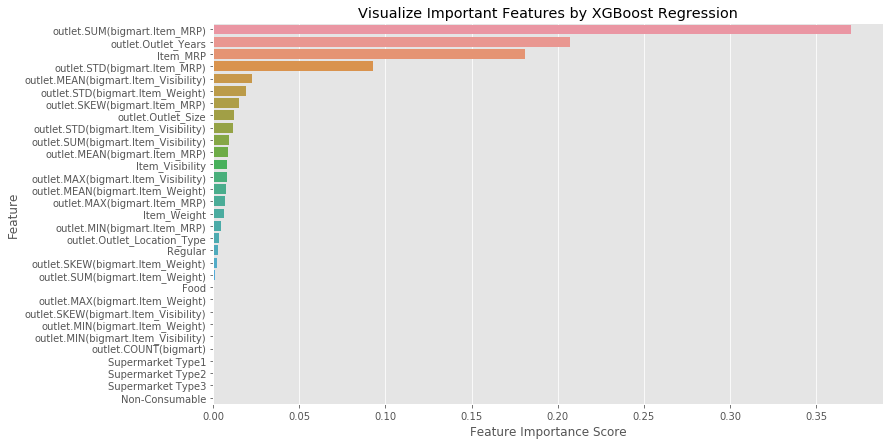

In [146]:
#Fit Random Forest Model to Training Set
xgb_reg.fit(X_train, y_train)

#Feature Contribution
feature_cols = X_train.columns
feature_imp = pd.Series(xgb_reg.feature_importances_, index = feature_cols).sort_values(ascending = False)
feature_imp

#Create Bar Plot
plt.figure(figsize=(12,7))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Visualize Important Features by XGBoost Regression')
plt.show()